In [15]:
## TASK 0

import torch
import os
import math
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm   # Progress bar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

print("Using torch", torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

# Define transformation given to apply to the data
transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),  # Random rotation up to 30 degrees
    transforms.RandomCrop(size=(28, 28)),   # Random crop to size 28x28
    transforms.ToTensor(),                  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))    # Normalize the pixel values to range [-1, 1]
])

# Download the MNIST dataset
full_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Split the full dataset into training and validation sets
train_dataset, val_dataset = train_test_split(full_dataset, test_size=0.2, random_state=42, shuffle=True)

# Download the test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders to iterate through the datasets in batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the size of the datasets
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))


Using torch 2.2.1+cu121
Device cpu
Training dataset size: 48000
Validation dataset size: 12000
Test dataset size: 10000


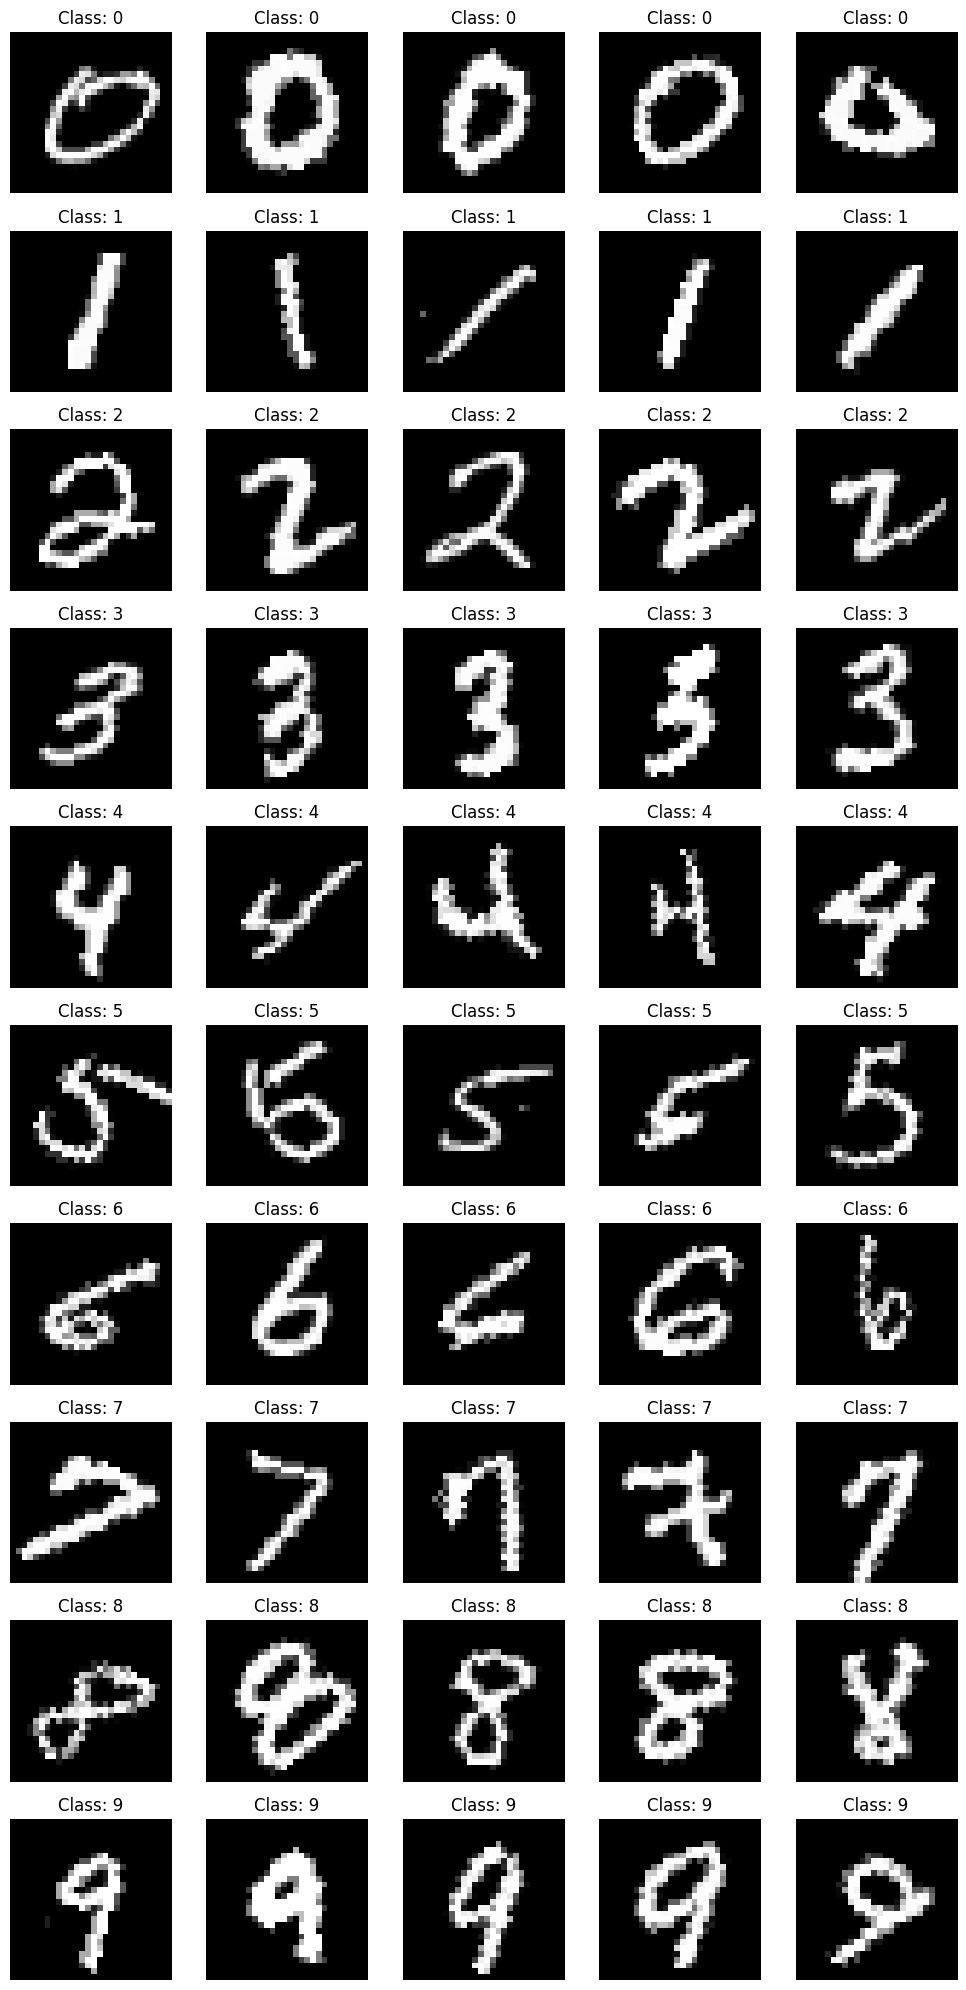

In [16]:
## TASK 1

import matplotlib.pyplot as plt

# Function to plot a few images from each class
def plot_images(dataset, num_images=5):
    # Get the unique classes in the dataset
    classes = list(set([label for _, label in dataset]))

    # Create a figure to hold the plots
    fig, axs = plt.subplots(len(classes), num_images, figsize=(num_images * 2, len(classes) * 2))

    # Iterate through each class
    for i, cls in enumerate(classes):
        # Get indices of images in the dataset belonging to this class
        indices = [idx for idx, (_, target) in enumerate(dataset) if target == cls]
        indices = indices[:num_images]  # Take only a few images from each class

        # Plot the images
        for j, idx in enumerate(indices):
            img, label = dataset[idx]
            axs[i, j].imshow(img.squeeze(), cmap='gray')
            axs[i, j].set_title(f"Class: {label}")
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Plot a few images from each class in the training dataset
plot_images(train_dataset)

# Create data loaders for the training dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create a data loader for the testing dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [17]:
## TASK 2

import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.f1 = nn.Linear(input_size, hidden_size1)
        self.f2 = nn.Linear(hidden_size1, hidden_size2)
        self.f3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)  # flatten input tensor except batch dimension
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = self.f3(x)
        return x

# Define the model
input_size = 28 * 28  # size of MNIST images
hidden_size1 = 128
hidden_size2 = 64
output_size = 10  # number of classes
three_layer_model = MLP(input_size, hidden_size1, hidden_size2, output_size)

# Print the number of trainable parameters
total_params = sum(p.numel() for p in three_layer_model.parameters() if p.requires_grad)
print("Number of trainable parameters:", total_params)


Number of trainable parameters: 109386


In [18]:
## TASK 3

import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(three_layer_model.parameters())

# Function to calculate accuracy
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

# Function to evaluate the model on a dataset
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_accuracy += accuracy(outputs, labels) * inputs.size(0)
    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)

# Training loop
num_epochs = 5
best_val_accuracy = 0.0
best_model = None

print("Training logs:")
for epoch in range(num_epochs):
    three_layer_model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = three_layer_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_accuracy += accuracy(outputs, labels) * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = running_accuracy / len(train_dataset)
    val_loss, val_accuracy = evaluate(three_layer_model, val_loader)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = three_layer_model.state_dict()

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save the best model
torch.save(best_model, 'best_model.pth')

Training logs:
Epoch [1/5], Train Loss: 0.5501, Train Accuracy: 0.8274, Val Loss: 0.3153, Val Accuracy: 0.9048
Epoch [2/5], Train Loss: 0.2874, Train Accuracy: 0.9108, Val Loss: 0.2745, Val Accuracy: 0.9136
Epoch [3/5], Train Loss: 0.2223, Train Accuracy: 0.9294, Val Loss: 0.2118, Val Accuracy: 0.9324
Epoch [4/5], Train Loss: 0.1878, Train Accuracy: 0.9405, Val Loss: 0.2355, Val Accuracy: 0.9234
Epoch [5/5], Train Loss: 0.1666, Train Accuracy: 0.9475, Val Loss: 0.1817, Val Accuracy: 0.9421


Training logs:
{'epoch': 1, 'train_loss': 0.14888680193790546, 'train_accuracy': 0.953125, 'val_loss': 0.19163671582688888, 'val_accuracy': 0.9385}
{'epoch': 2, 'train_loss': 0.1314476223460709, 'train_accuracy': 0.9581875, 'val_loss': 0.17875104474524656, 'val_accuracy': 0.9453333333333334}
{'epoch': 3, 'train_loss': 0.12036363267153502, 'train_accuracy': 0.9610208333333333, 'val_loss': 0.18464990044323107, 'val_accuracy': 0.9469166666666666}
{'epoch': 4, 'train_loss': 0.10876864690178384, 'train_accuracy': 0.9645833333333333, 'val_loss': 0.1775790196483334, 'val_accuracy': 0.9475833333333333}
{'epoch': 5, 'train_loss': 0.10159793468937278, 'train_accuracy': 0.9662916666666667, 'val_loss': 0.17134412977285682, 'val_accuracy': 0.9493333333333334}


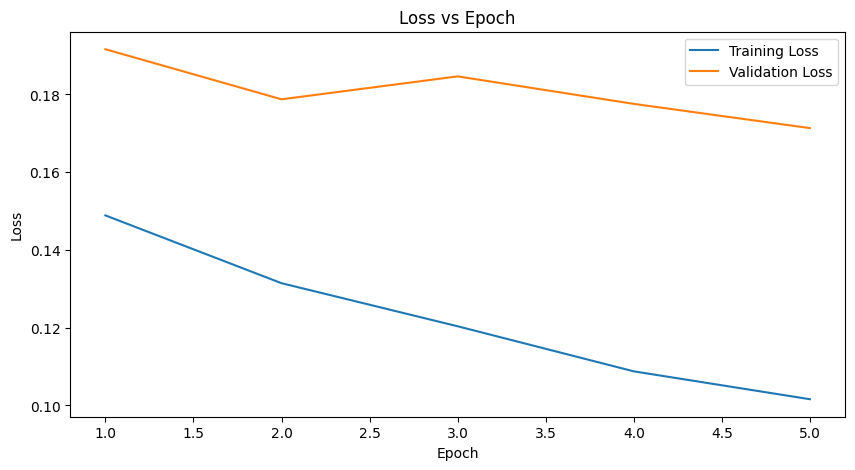

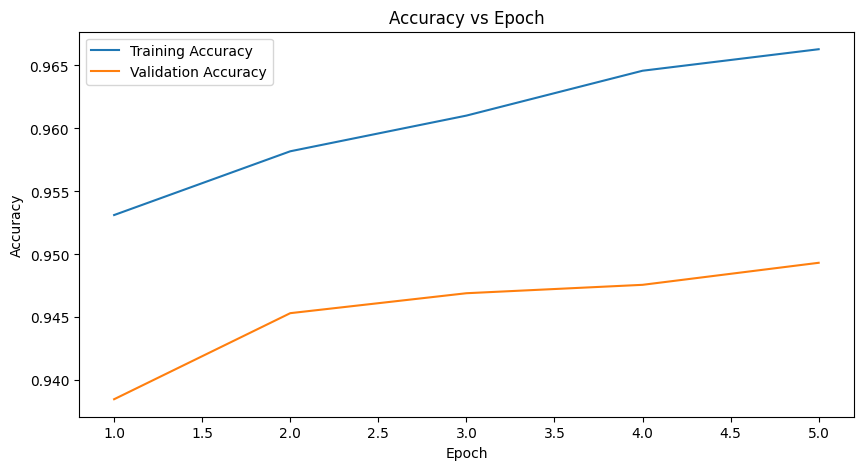

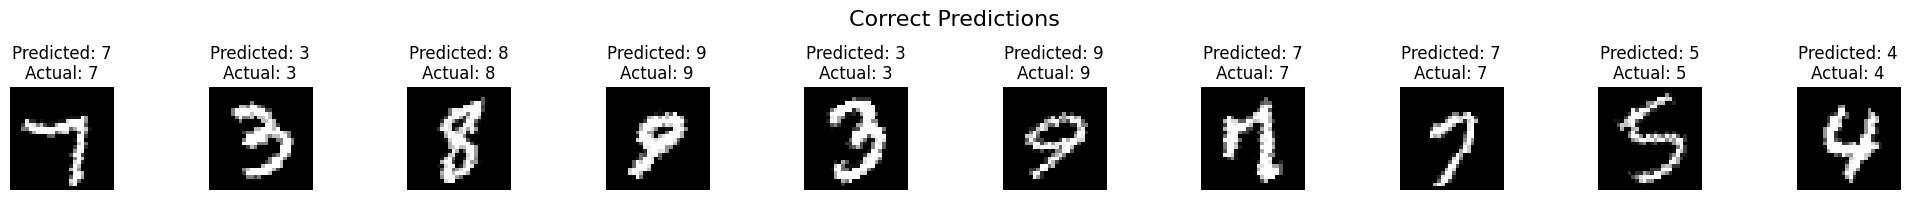

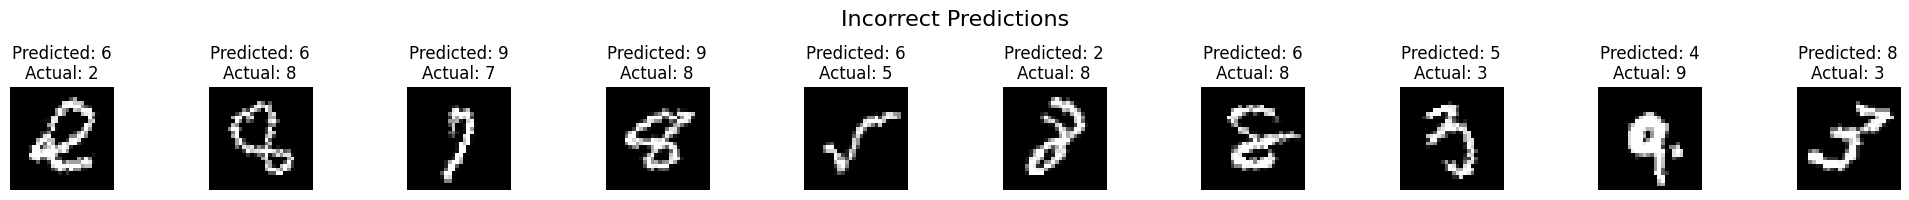

In [19]:
## TASK 4

import torch.optim as optim
import matplotlib.pyplot as plt

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(three_layer_model.parameters())

# Function to calculate accuracy
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

# Function to evaluate the model on a dataset
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_accuracy += accuracy(outputs, labels) * inputs.size(0)
            all_preds.extend(torch.argmax(outputs, dim=1).tolist())
            all_labels.extend(labels.tolist())
    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset), all_preds, all_labels

# Training loop
num_epochs = 5
best_val_accuracy = 0.0
best_model = None
training_logs = []

for epoch in range(num_epochs):
    three_layer_model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    correct_preds = []
    incorrect_preds = []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = three_layer_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_accuracy += accuracy(outputs, labels) * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct_preds.extend([i for i, pred in enumerate(preds) if pred == labels[i]])
        incorrect_preds.extend([i for i, pred in enumerate(preds) if pred != labels[i]])

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = running_accuracy / len(train_dataset)
    val_loss, val_accuracy, val_preds, val_labels = evaluate(three_layer_model, val_loader)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = three_layer_model.state_dict()

    # Log the accuracy and loss
    epoch_log = {
        'epoch': epoch + 1,
        'train_loss': epoch_loss,
        'train_accuracy': epoch_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }
    training_logs.append(epoch_log)

# Save the best model
torch.save(best_model, 'best_model.pth')

# Print training logs
print("Training logs:")
for log in training_logs:
    print(log)

# Plotting
epochs = range(1, num_epochs + 1)

# Loss vs Epoch
plt.figure(figsize=(10, 5))
plt.plot(epochs, [log['train_loss'] for log in training_logs], label='Training Loss')
plt.plot(epochs, [log['val_loss'] for log in training_logs], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy vs Epoch
plt.figure(figsize=(10, 5))
plt.plot(epochs, [log['train_accuracy'] for log in training_logs], label='Training Accuracy')
plt.plot(epochs, [log['val_accuracy'] for log in training_logs], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize correct and incorrect predictions
def visualize_predictions(dataset, preds, labels, correct=True, num_samples=5):
    classes = range(10)

    if correct:
        title = 'Correct Predictions'
        indices = [i for i, pred in enumerate(preds) if pred == labels[i]]
    else:
        title = 'Incorrect Predictions'
        indices = [i for i, pred in enumerate(preds) if pred != labels[i]]

    indices = indices[:num_samples]
    num_cols = num_samples
    num_rows = 1

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    fig.suptitle(title, fontsize=16)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        if num_rows == 1:
            ax = axs[i % num_cols]
        else:
            ax = axs[i // num_cols, i % num_cols]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Predicted: {preds[idx]}\nActual: {label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize correct predictions
visualize_predictions(val_dataset, val_preds, val_labels, correct=True, num_samples=10)

# Visualize incorrect predictions
visualize_predictions(val_dataset, val_preds, val_labels, correct=False, num_samples=10)